# Fit GPs to TESS data

Can a damped, driven simple harmonic oscillator model the TESS data effectively?  To what extent can multiple peaks be explained as phase drift?

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [5]:
from astropy.stats import LombScargle
import astropy.units as u
from astropy.time import Time

In [6]:
import celerite
from celerite import terms

In [7]:
import lightkurve as lk

## Retrieve custom-made lightkurve data

We'll retrieve the custom made lightcurve that we saved.

In [8]:
lc_raw = lk.TessLightCurve.read('../data/TESS/lightkurve_custom_4pixel.fits', format='tess').normalize()

In [9]:
snr = lc_raw.flux/lc_raw.flux_err
np.round(np.percentile(snr, (5, 50, 95)))

<Quantity [ 94., 146., 151.]>

In [10]:
threshold1L, threshold1R = 1572, 1581.7
threshold2L, threshold2R = 1585, 1595.7

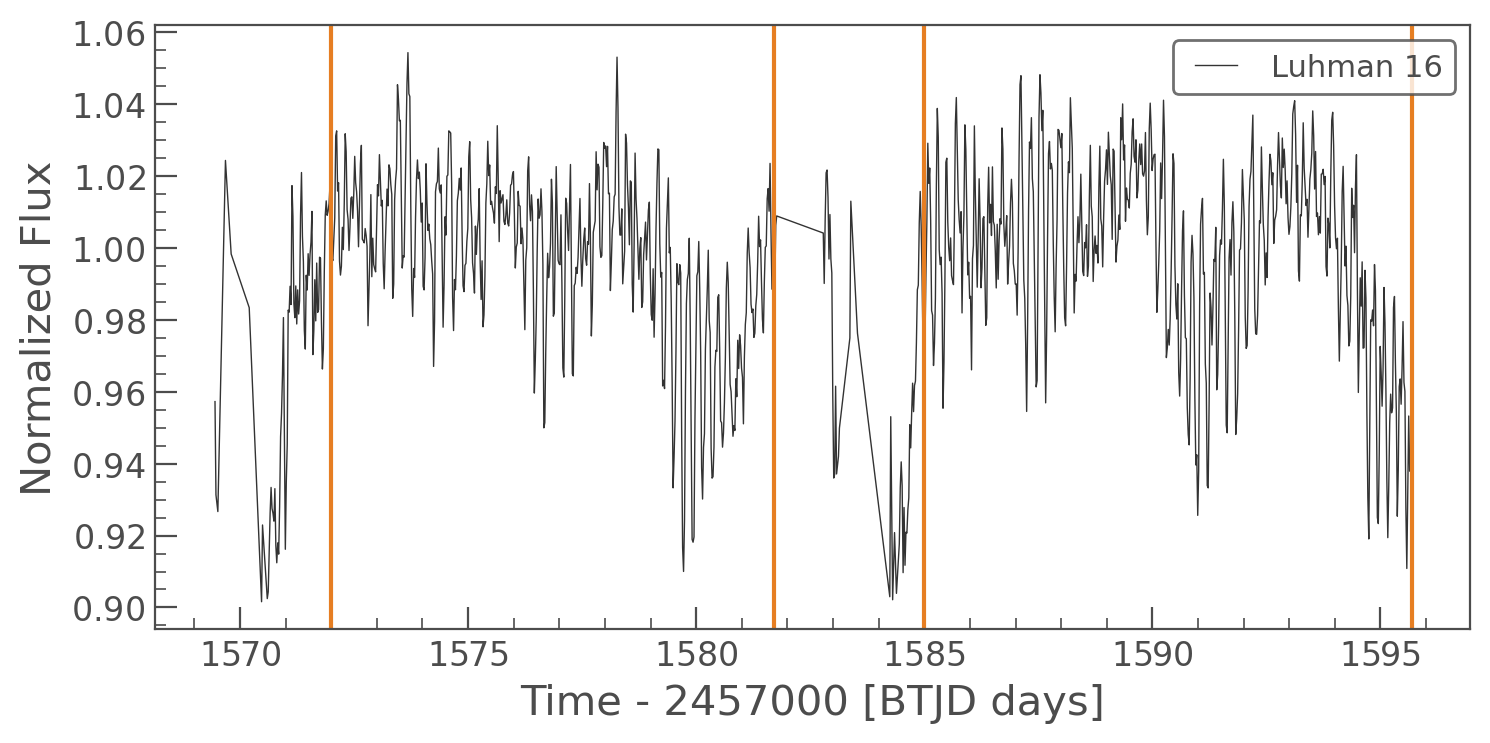

In [11]:
ax = lc_raw.plot();
#ax.set_ylim(0.85, 1.1)
ax.axvline(threshold1L, color='#e67e22');ax.axvline(threshold1R, color='#e67e22');
ax.axvline(threshold2L, color='#e67e22');ax.axvline(threshold2R, color='#e67e22');

The signal-to-noise ratio is typically better than 100 per pixel.

### Trim the noisy parts when the telescope is thermally settling.
Between the two sets of vertical lines above.

In [12]:
mask1 = (lc_raw.time.value > threshold1L) & (lc_raw.time.value < threshold1R)
mask2 = (lc_raw.time.value > threshold2L) & (lc_raw.time.value < threshold2R)

Let's just look at one segment for now.

In [13]:
lc = lc_raw[mask1 | mask2]

In [14]:
lc.time.min().iso, lc.time.max().iso

('2019-03-29 12:21:16.172', '2019-04-22 03:50:53.320')

## Make the Power Spectrum

Let's create the power spectrum separately for each campaign.  This approach allows us to not worry about the mean level that we assign to each campaign, and it helps see which PSD structures persist from campaign to campaign.

In [15]:
pg = lc.to_periodogram(normalization='psd', freq_unit=1/u.day, oversample_factor=10)

In [16]:
lc_noise = lc.copy()
lc_noise.flux = np.random.normal(1, scale=lc.flux_err)

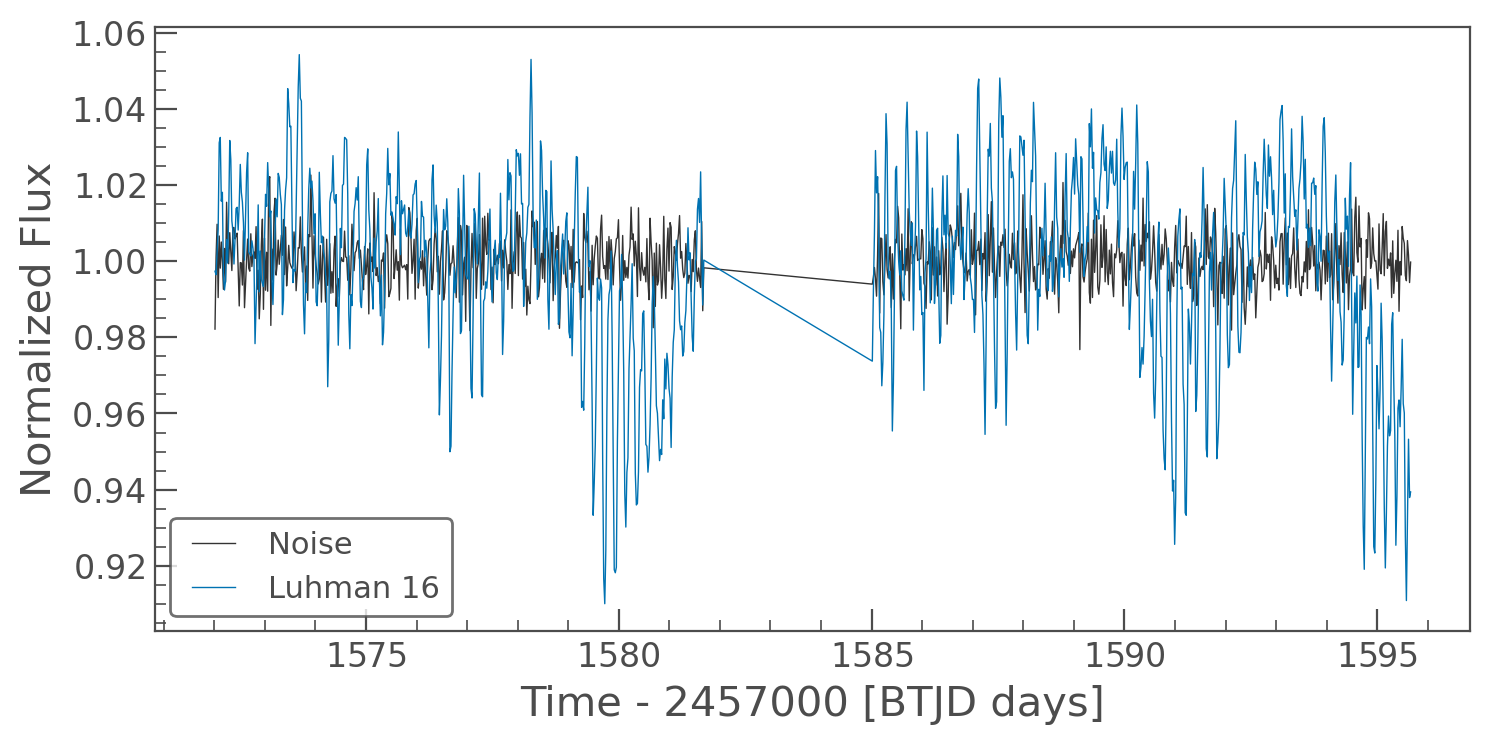

In [17]:
ax = lc_noise.plot(label='Noise')
lc.plot(ax=ax);

In [18]:
pg_noise = lc_noise.to_periodogram(normalization='psd', freq_unit=1/u.day, oversample_factor=10)

In [19]:
n_draws = 251

In [20]:
peak_period = 5.28 * u.hour
peak_frequency = (1.0/(peak_period.to(u.day)))

alt_period = 6.94 * u.hour
alt_frequency = 1.0/(alt_period.to(u.day))

Construct a noise region

In [21]:
noise_power_draws = []

In [22]:
for i in range(n_draws):
    lc_noise = lc.copy()
    lc_noise.flux = np.random.normal(1, scale=lc.flux_err)
    pg_noise = lc_noise.to_periodogram(normalization='psd', freq_unit=1/u.day, oversample_factor=10)
    pg_noise.plot(ax=ax, scale='log', label=None, alpha=0.1, color='#c0392b')
    noise_power_draws.append(pg_noise.power.value)

In [23]:
lo, med, hi = np.percentile(noise_power_draws, (15.9, 50.0, 84.1), axis=0)

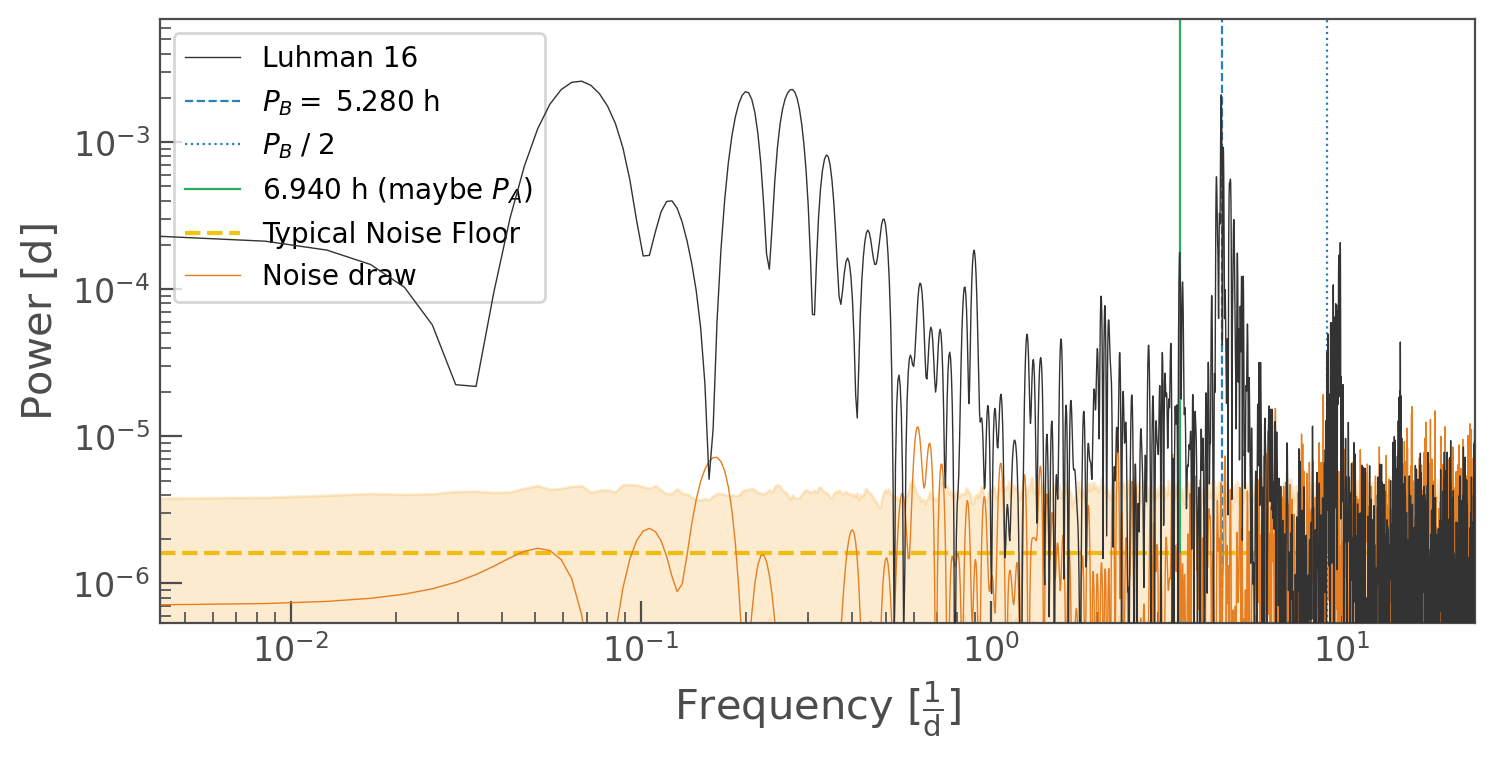

In [24]:
ax = pg.plot(scale='log', zorder=10)
ax.set_ylim(med.mean()/3);
ax.axvline(peak_frequency.value, color='#2980b9', linestyle='dashed', 
           label='$P_B = $ {:0.3f}'.format(peak_period),linewidth=0.8)
ax.axvline(peak_frequency.value*2, color='#2980b9', linestyle='dotted', 
           label='$P_B \; /\; 2$'.format(peak_period/2),linewidth=0.8)
ax.axvline(alt_frequency.value, color='#27ae60', linestyle='solid', 
           label='{:0.3f} (maybe $P_A$)'.format(alt_period),linewidth=0.8)
ax.axhline(med.mean(), color='#f1c40f', linestyle='dashed', label='Typical Noise Floor', zorder=-1)

#plt.plot(pg.frequency, med, color='#95a5a6')

pg_noise.plot(ax=ax, scale='log', label='Noise draw', color='#e67e22')

plt.fill_between(pg.frequency, lo, hi, color='#f39c12', alpha=0.2, zorder=0)
#pg_noise.plot(ax=ax, scale='log', label='Noise Draw', alpha=0.5)
plt.legend(loc='best')
ax.set_xlim(pg.frequency[0].value, pg.frequency[-1].value);

The lightkurve power scale factor is:  
$$ \tilde P_{lk} = P_{lk} \cdot \frac{2 T}{N}$$

Where the tilde represents the rescaled, and  
$N$ is the number of samples  
$T$ is the total observation window duration, in say, days or $\frac{1}{\mathrm{Hz}}$

The *celerité* power scale **expects** a rescaling of Lomb Scargle power:
$$ \tilde P_{LS} = P_{LS} \cdot \frac{1}{N}$$  
*assuming* the `.get_psd()` power is scaled by $ \tilde P_c = P_c \cdot \frac{2}{T}$.

So to get them to match up, we can simply divide the lightkurve power by $2T$, **or** multiply the `celerite` power $\tilde P_c$ by $2T$, yielding: 

$ \hat P_c = \tilde P_c \cdot 2T = P_c \cdot \frac{2}{T}\cdot 2T =  4P_c $


My inclination is to leave lightkurve as perfect, and rescale celerite.

In [25]:
variance = np.var(lc.flux)

#### A periodic term

In [26]:
guess_period = peak_period.to(u.day).value
guess_period

0.22

In [27]:
Q_guess = 400
w0_guess = 2.0*np.pi / guess_period
S0_guess = variance /3600

bounds1 = dict(log_S0=(np.log(variance/1000000), np.log(variance*100000)),
               log_Q=(np.log(3), np.log(1000000)), 
               log_omega0=(np.log(w0_guess*0.8),np.log(w0_guess*1.2)))

kernel_sho = terms.SHOTerm(log_S0=np.log(S0_guess), log_Q=np.log(Q_guess), 
                       log_omega0=np.log(w0_guess))#, bounds=bounds1)

#### A second periodic term

In [28]:
guess_period2 = guess_period / 2 # 2.5 / 24.0 * 1.0

In [29]:
Q2_guess = 100
w02_guess = 2.0*np.pi / guess_period2
S02_guess = variance /9000

bounds_sho2 = dict(log_S0=(np.log(variance/10000), np.log(variance*1000)),
               log_Q=(np.log(3), np.log(2000)), 
               log_omega0=(np.log(w02_guess*0.8),np.log(w02_guess*1.2)))

kernel_sho2 = terms.SHOTerm(log_S0=np.log(S02_guess), log_Q=np.log(Q2_guess), 
                       log_omega0=np.log(w02_guess))#, bounds=bounds_sho2)

#### A Matern term

>   log_sigma (float): The log of the parameter $\sigma$.  

>    log_rho (float): The log of the parameter $\rho$.   
    
>    eps (Optional[float]): The value of the parameter $\epsilon$.   
        (default: `0.01`)

In [30]:
sigma_guess = np.sqrt(variance)/10
rho_guess =  guess_period2 / 10.0

kernel_mat = terms.Matern32Term(log_sigma=np.log(sigma_guess), log_rho=np.log(rho_guess))

#### A Jitter term

In [31]:
kernel_jit = terms.JitterTerm(log_sigma=np.log(lc.flux_err.mean()))

#### Compute the GP

In [32]:
net_kernel = kernel_sho + kernel_sho2 + kernel_mat #+ kernel_jit
gp = celerite.GP(net_kernel, fit_mean=True, mean=lc.flux.mean())
gp.compute(lc.time.value, yerr=lc.flux_err.value)

In [33]:
f = pg.frequency.value

In [34]:
power_true = net_kernel.get_psd(2*np.pi*f) * 4
power_sho1 = kernel_sho.get_psd(2*np.pi*f) * 4
power_sho2 = kernel_sho2.get_psd(2*np.pi*f) * 4
power_mat = kernel_mat.get_psd(2*np.pi*f) * 4

In [35]:
flux_draw = gp.sample()

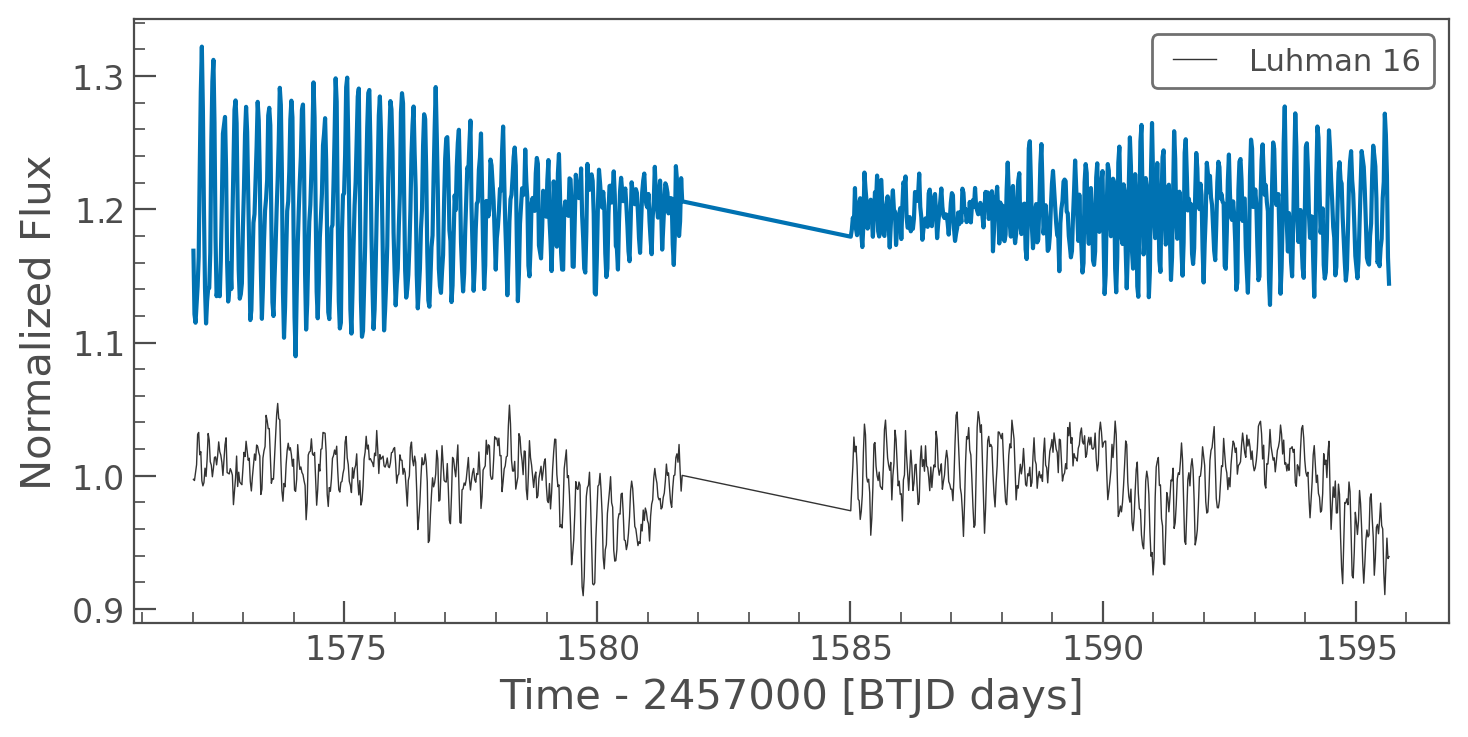

In [37]:
ax = lc.plot()
ax.plot(lc.time.value, gp.sample()+0.2);

Plausibly in the same ballpark--- good enough for an initial guess.

In [38]:
lc_draw = lc.copy()
lc_draw.flux = gp.sample() * lc.flux.unit
pg_draw = lc_draw.to_periodogram(normalization='psd', freq_unit=1/u.day, oversample_factor=10)

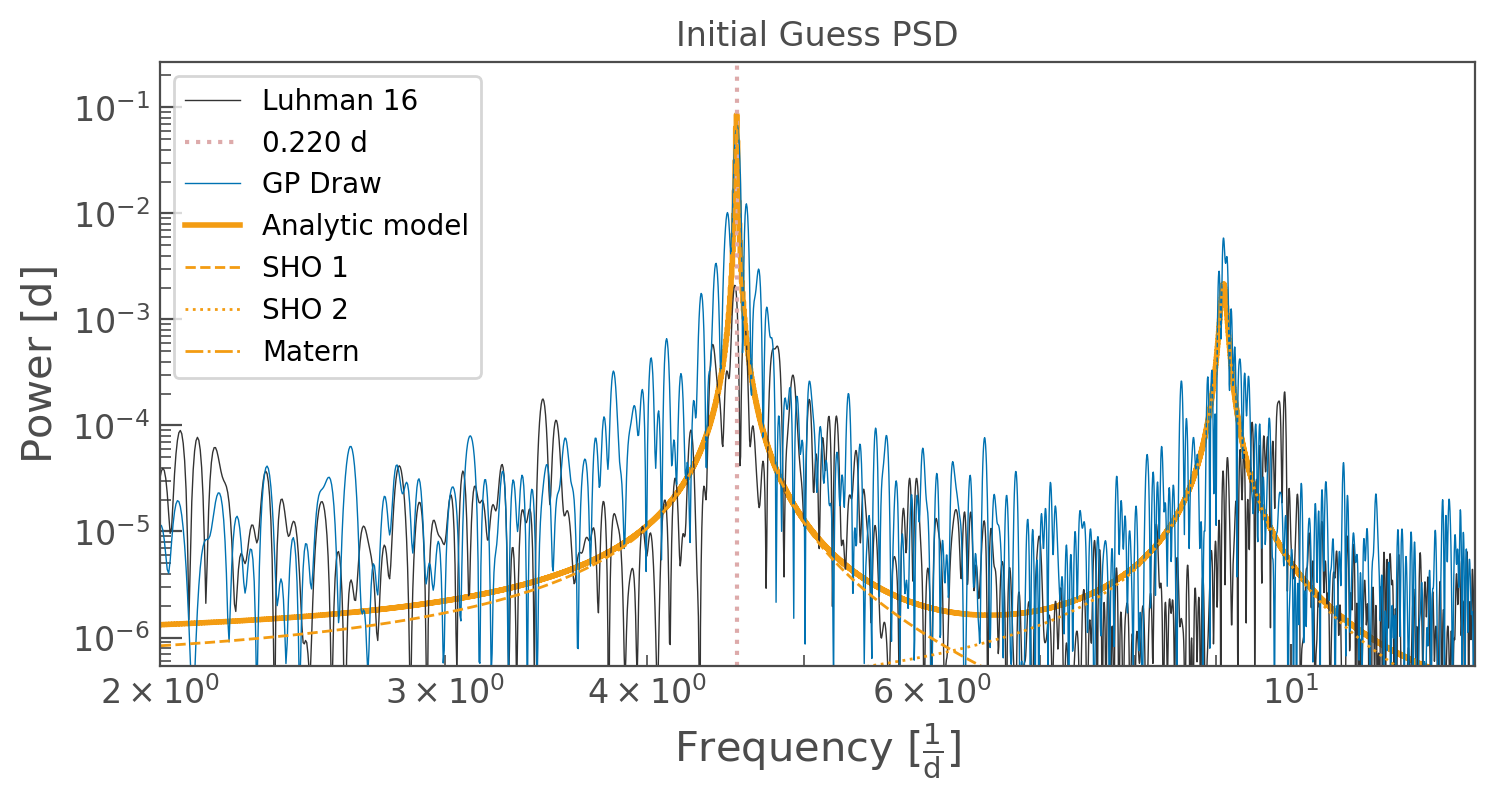

In [39]:
ax = pg.plot(scale='log')
ax.axvline(1.0/guess_period, color='#ddaaaa', linestyle='dotted', label='{:0.3f} d'.format(guess_period), alpha=1)
pg_draw.plot(ax=ax, label='GP Draw', scale='log')
ax.step(pg.frequency, power_true, color='#f39c12', lw=2,label="Analytic model", where='mid', zorder=0)

ax.plot(f, power_sho1, color='#f39c12', lw=1,label="SHO 1", linestyle='--')
ax.plot(f, power_sho2, color='#f39c12', lw=1,label="SHO 2", linestyle=':')
ax.plot(f, power_mat, color='#f39c12', lw=1,label="Matern", linestyle='-.')

plt.ylim(med.mean()/3)
ax.set_xlim(pg.frequency[0].value, pg.frequency[-1].value);
plt.legend(loc='best')
ax.set_xlim(2, 13)
plt.title('Initial Guess PSD');

Awesome!  Let's spot-check our results by making a draw from the model and then computing as if it were data.

In [40]:
y = lc.flux.value

In [41]:
# Set up the GP model

print("Initial log-likelihood: {0}".format(gp.log_likelihood(y)))

Initial log-likelihood: 1186.4354943197295


Define a likelihood function

In [42]:
def neg_log_like(params, y, gp1):
    gp1.set_parameter_vector(params)
    return -gp1.log_likelihood(y)

def grad_neg_log_like(params, y, gp1):
    gp1.set_parameter_vector(params)
    return -gp1.grad_log_likelihood(y)[1]

In [43]:
from scipy.optimize import minimize

### Refine the GP parameters with optimization

In [44]:
%%time
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=None, args=(y, gp))

CPU times: user 2.4 s, sys: 0 ns, total: 2.4 s
Wall time: 2.39 s


 Spot check the optimization results.

In [45]:
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

Final log-likelihood: 3113.3457284747706


In [46]:
t_pred = np.linspace(lc.time.value[0], lc.time.value[-1], num=10000)

In [47]:
# Make the maximum likelihood prediction
mu, var = gp.predict(y, t_pred, return_var=True)
std = np.sqrt(var)

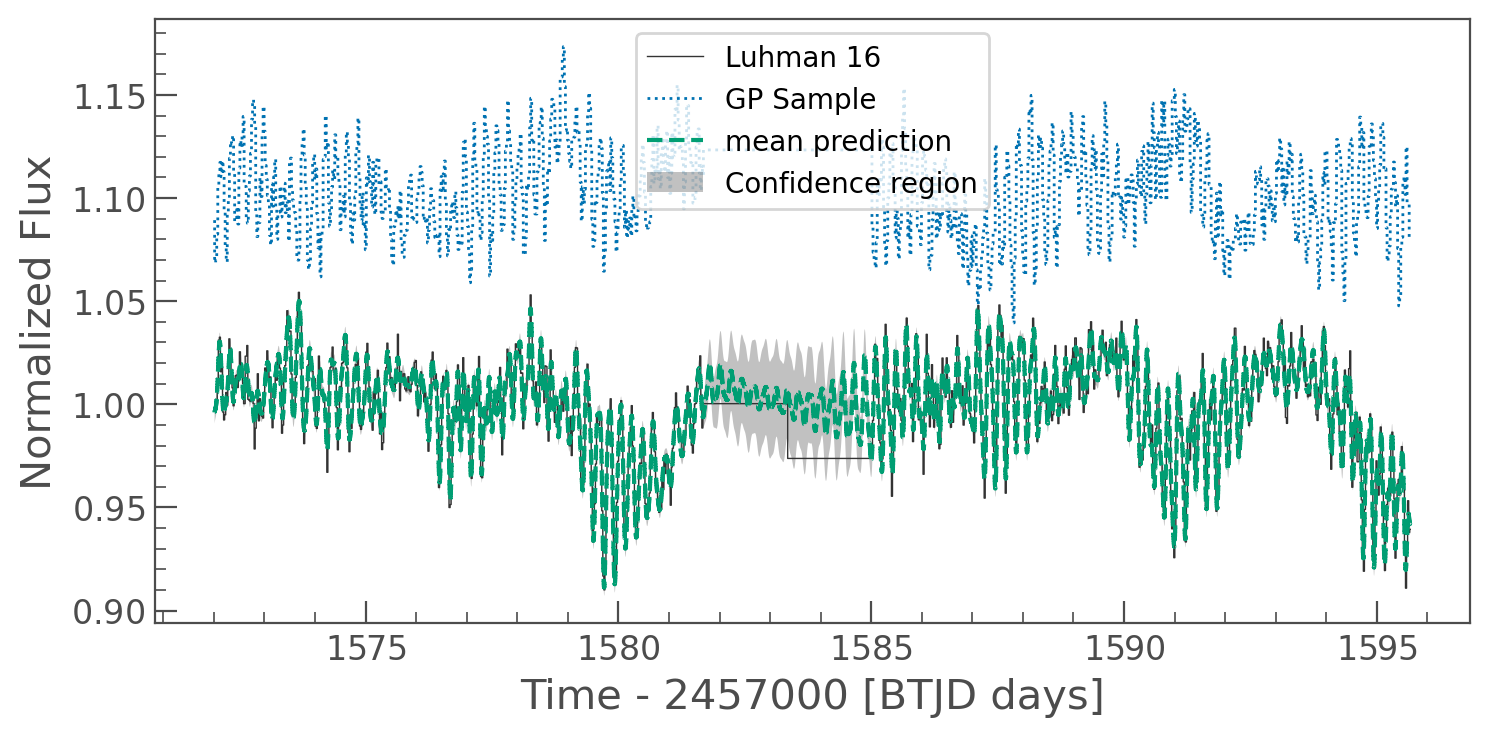

In [48]:
ax = lc.plot(drawstyle='steps-mid')
ax.step(lc.time.value, gp.sample()+0.1, label='GP Sample', lw=1, linestyle=':')
ax.step(t_pred, mu, label='mean prediction', alpha=1, linestyle='dashed')
ax.fill_between(t_pred, mu-std, mu+std, label='Confidence region', alpha=0.3)
ax.legend();

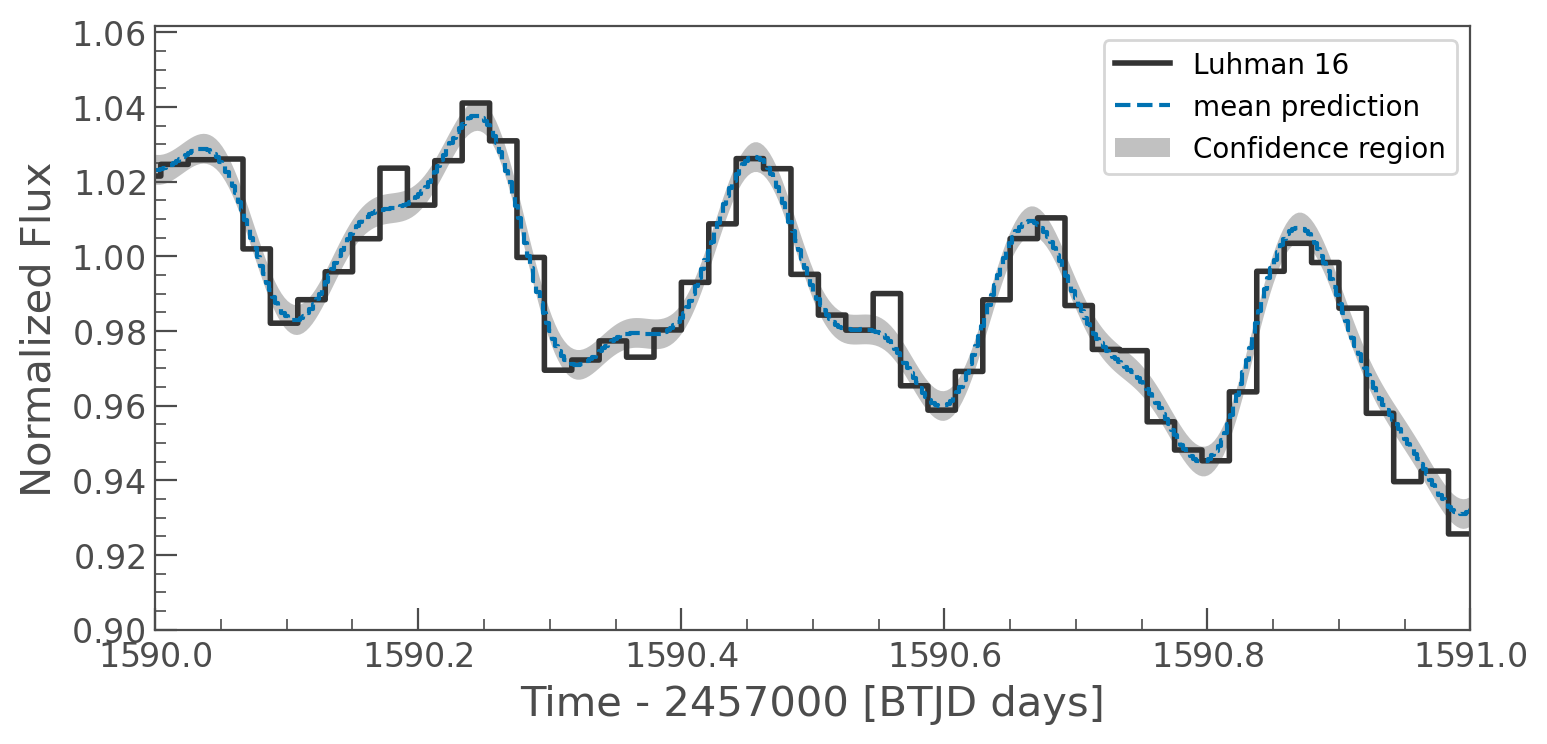

In [49]:
ax = lc.plot(drawstyle='steps-mid', linewidth=2)
#ax.step(lc.time.value, gp.sample(), label='GP Sample', lw=1)
ax.step(t_pred, mu, label='mean prediction', alpha=1, linestyle='dashed')
ax.fill_between(t_pred, mu-std, mu+std, label='Confidence region', alpha=0.3)
ax.set_xlim(1590, 1590+1)
#ax.set_ylim(0.992, 0.998)
plt.legend();

In [50]:
this_power = gp.kernel.get_psd(2*np.pi*f) * 4

In [51]:
pg_analytic = pg_noise.copy()

In [52]:
pg_analytic.power = this_power*pg_noise.power.unit

Improve the $S/N$ on the periodogram of GP draws.

In [53]:
%%time
lc_draw = lc.copy()
many_draw = []
for i in range(100):
    lc_draw.flux = gp.sample()
    pg_draw = lc_draw.to_periodogram(normalization='psd', freq_unit=1/u.day, oversample_factor=10)
    many_draw.append(pg_draw.power)
    
pg_draw.power = np.median(np.array(many_draw), axis=0)*pg_draw.power.unit

CPU times: user 459 ms, sys: 0 ns, total: 459 ms
Wall time: 458 ms


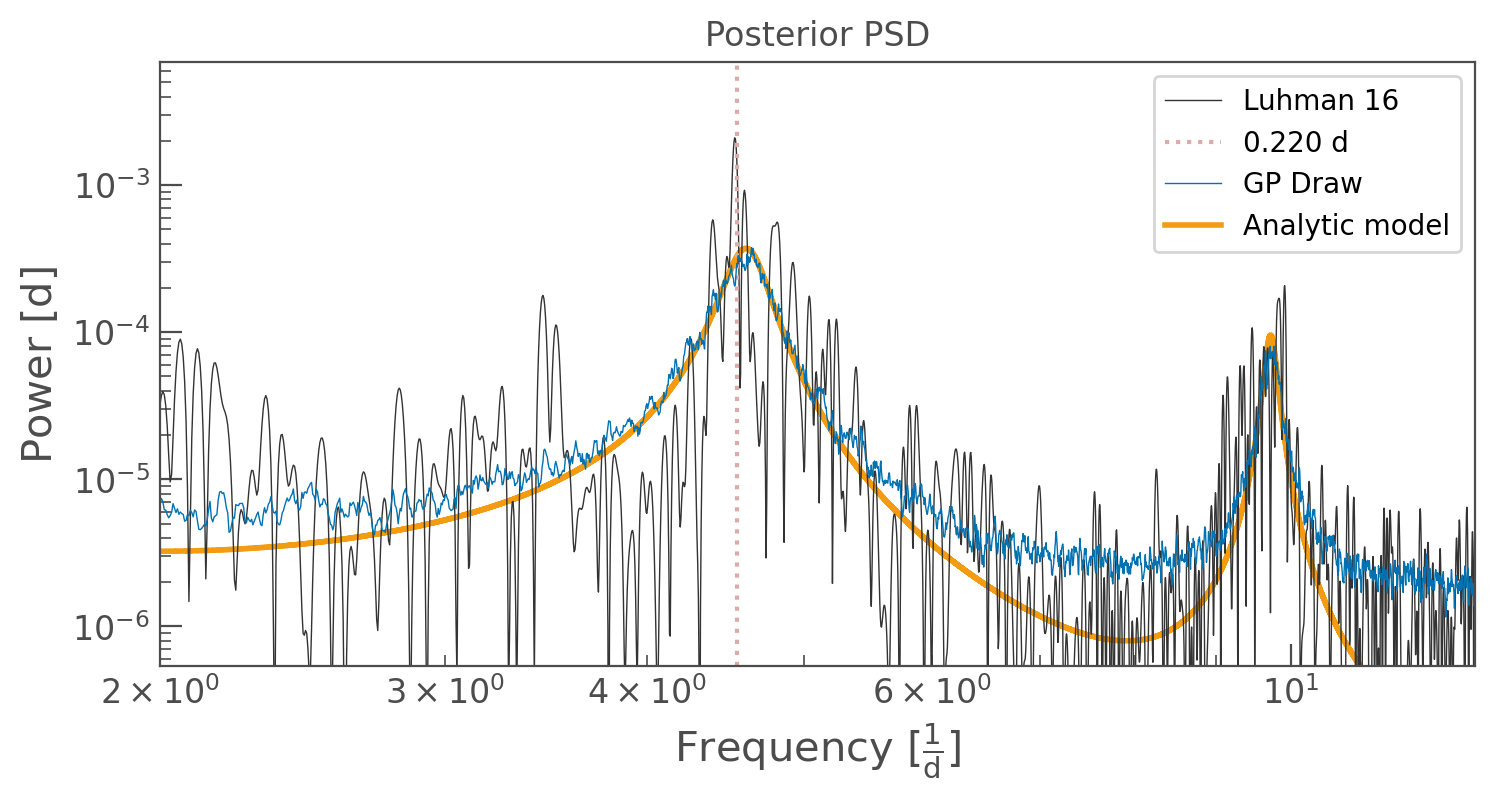

In [54]:
ax = pg.plot(scale='log')
ax.axvline(1.0/guess_period, color='#ddaaaa', linestyle='dotted', label='{:0.3f} d'.format(guess_period), alpha=1)
pg_draw.plot(ax=ax, label='GP Draw', scale='log')
ax.step(pg.frequency, this_power, color='#f39c12', lw=2,label="Analytic model", where='mid', zorder=0)

#ax.plot(f, power_sho1, color='#f39c12', lw=1,label="SHO 1", linestyle='--')
#ax.plot(f, power_sho2, color='#f39c12', lw=1,label="SHO 2", linestyle=':')
#ax.plot(f, power_mat, color='#f39c12', lw=1,label="Matern", linestyle='-.')

plt.ylim(med.mean()/3)
ax.set_xlim(pg.frequency[0].value, pg.frequency[-1].value);
plt.legend(loc='best')
ax.set_xlim(2, 13)
plt.title('Posterior PSD');

Hmmm, to be continued!  There really is structure there above-and-beyond windowing effects.  The True TESS lightcurve does share resemble exactly the same SHO wings of our simple heuristic model.  This discrepancy suggests there is not a continuum of phases (or periods), but a structure phase distribution (or a-symmetric, discrete period distribution).  I think the next steps are:

### 1. Model more periods  
Possibly most of the micro-periods we see here should get their own SHO (and prior to keep it stable).

### 2. Make a differential rotation model with Starry  
We seek a generative model for the data, especially one that can inform spectroscopy.  Unfortunately making such a differential rotation map is unproven technology.

### 3. Explore resonance beat phenomenon  
Two similarly rotating periods should cause a beat phenomenon.  Can we see it?